# IMPORT LIBRARY


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib

# LOAD DATA

In [ ]:
df = pd.read_csv("/content/predictive_maintenance.csv")

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# CEK STRUKTUR DATA

In [ ]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


# DATA CLEANING


In [ ]:
drop_cols = ["UDI", "Product ID"]  # ganti sesuai dataset Anda
drop_cols = [c for c in drop_cols if c in df.columns]

df = df.drop(columns=drop_cols, errors="ignore")


In [ ]:
df = df.rename(columns={
    'Air temperature [K]': 'air_temp',
    'Process temperature [K]': 'process_temp',
    'Rotational speed [rpm]': 'rpm',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear',
    'Failure Type': 'failure'
})


In [ ]:
df.isnull().sum()


,0
Type,0
air_temp,0
process_temp,0
rpm,0
torque,0
tool_wear,0
Target,0
failure,0


In [ ]:
df.duplicated().sum()
df = df.drop_duplicates()

In [ ]:
num_cols = ['air_temp', 'process_temp', 'rpm', 'torque', 'tool_wear']

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dtypes


,0
Type,object
air_temp,float64
process_temp,float64
rpm,int64
torque,float64
tool_wear,int64
Target,int64
failure,object


In [ ]:
#IQR

def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers_iqr(df, num_cols)


<Figure size 1200x600 with 0 Axes>

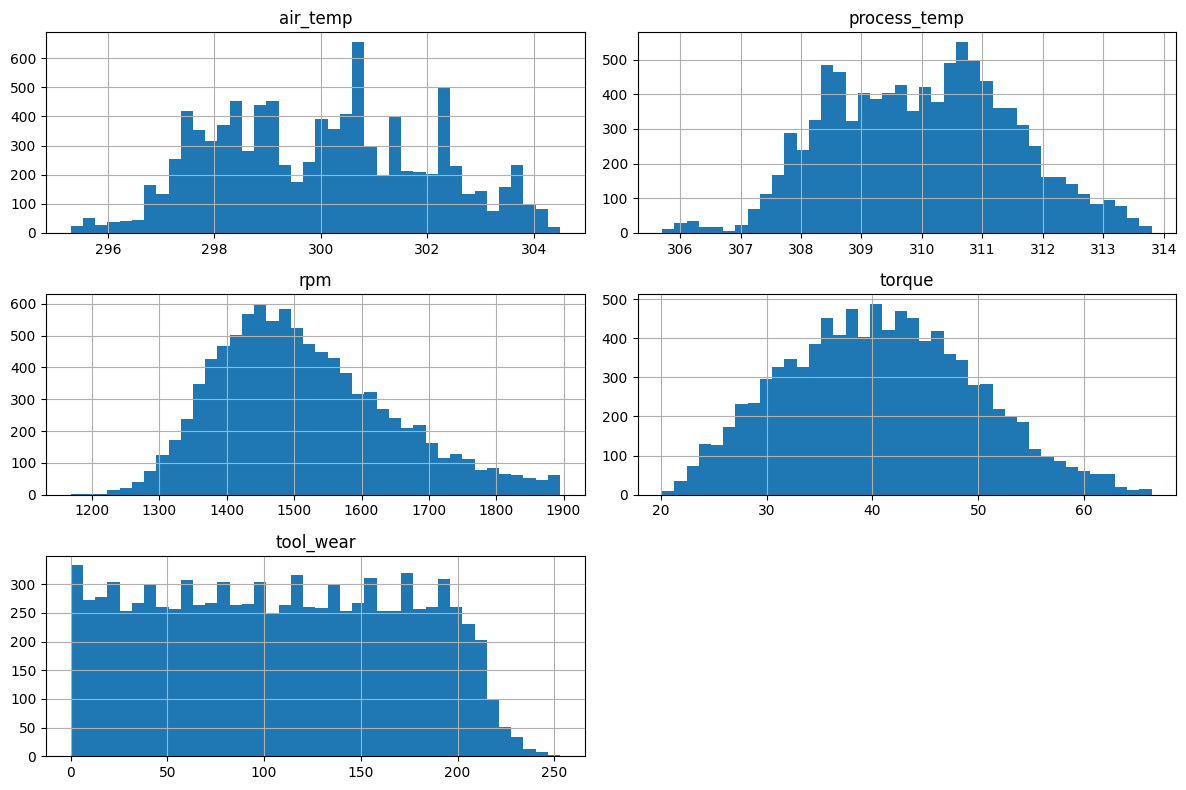

In [ ]:
plt.figure(figsize=(12,6))
df[num_cols].hist(bins=40, figsize=(12,8))
plt.tight_layout()
plt.show()


In [ ]:
df['failure'].value_counts()


,count
failure,
No Failure,9263
Heat Dissipation Failure,110
Overstrain Failure,76
Tool Wear Failure,41
Power Failure,27
Random Failures,18


encode


# Preprocess

In [ ]:
label_encoders = {}

cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = [c for c in cat_cols if c != "failure"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [ ]:
target_encoder = LabelEncoder()
df["failure"] = target_encoder.fit_transform(df["failure"])


# Splitting


In [ ]:
X = df[["Type", "air_temp", "process_temp", "rpm", "torque", "tool_wear"]]
y = df["failure"]

# Scalling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Menangani Imbalance

In [ ]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Modeling

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(target_encoder.classes_),
    eval_metric='mlogloss',
    seed=42
)


In [ ]:
model.fit(X_train_bal, y_train_bal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=6, ...)

# Evaluasi

In [ ]:
joblib.dump(model, "model_failure.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(target_encoder, "target_encoder.pkl")

['target_encoder.pkl']

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Akurasi XGBoost:", accuracy)


Akurasi XGBoost: 0.961719979024646


In [ ]:
print("Distribusi kelas setelah SMOTE:")
print(y_train_bal.value_counts())


Distribusi kelas setelah SMOTE:
failure
1    7410
2    7410
0    7410
4    7410
5    7410
3    7410
Name: count, dtype: int64


In [ ]:
print("Persentase kelas setelah SMOTE:")
print(y_train_bal.value_counts(normalize=True) * 100)


Persentase kelas setelah SMOTE:
failure
1    16.666667
2    16.666667
0    16.666667
4    16.666667
5    16.666667
3    16.666667
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import pandas as pd

# ============================
# Contoh data baru untuk prediksi
# ============================

sample = np.array([[1, 298.8, 308.9, 1455, 41.3, 208]])

df_sample = pd.DataFrame(sample, columns=X.columns)

# ============================
# Scaling menggunakan scaler yang sama
# ============================

sample_scaled = scaler.transform(df_sample)

# ============================
# Prediksi dengan model XGBoost
# ============================

prediction = model.predict(sample_scaled)

# ============================
# Mengembalikan label asli
# ============================

predicted_label = target_encoder.inverse_transform(prediction)
print("Prediksi failure:", predicted_label[0])


Prediksi failure: Tool Wear Failure
